<a href="https://colab.research.google.com/github/khan-habibullah/ml1/blob/master/LSTM_on_stock_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau
%matplotlib inline

In [5]:
dataset_train = pd.read_csv('/content/GOOG.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (3817, 7)
All timestamps == 3817
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


In [6]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (3817, 5).


array([[16.217712, 16.373629, 16.071012, 16.284462, 16.284462],
       [16.0872  , 16.165657, 15.825183, 15.881721, 15.881721],
       [15.665532, 15.940003, 14.992056, 15.341247, 15.341247],
       ...,
       [94.489998, 95.919998, 92.355003, 92.660004, 92.660004],
       [92.5     , 93.18    , 90.800003, 91.010002, 91.010002],
       [90.565002, 93.080002, 89.940002, 91.660004, 91.660004]])

In [7]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.78346933],
       [-0.78706785],
       [-0.79869423],
       ...,
       [ 1.37468058],
       [ 1.31981168],
       [ 1.26645926]])

In [8]:



# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3668, 90, 4).
y_train shape == (3668, 1).


In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [10]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [12]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
 9/12 [=====================>........] - ETA: 0s - loss: 0.1912
Epoch 1: val_loss improved from inf to 0.98360, saving model to weights.h5
12/12 [==============================] - 7s 82ms/step - loss: 0.1598 - val_loss: 0.9836 - lr: 0.0100
Epoch 2/30
 9/12 [=====================>........] - ETA: 0s - loss: 0.0358
Epoch 2: val_loss improved from 0.98360 to 0.92207, saving model to weights.h5
12/12 [==============================] - 0s 20ms/step - loss: 0.0344 - val_loss: 0.9221 - lr: 0.0100
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.0265
Epoch 3: val_loss did not improve from 0.92207
12/12 [==============================] - 0s 15ms/step - loss: 0.0266 - val_loss: 1.2493 - lr: 0.0100
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 0.0245
Epoch 4: val_loss did not improve from 0.92207
12/12 [==============================] - 0s 14ms/step - loss: 0.0245 - val_loss: 1.4834 - lr: 0.0100
Epoch 5/30
 7/12 [================>.............

In [13]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [14]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

112/112 [==============================] - 1s 5ms/step


In [15]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Open
2008-12-23,12.866373
2008-12-24,12.769077
2008-12-26,12.669079


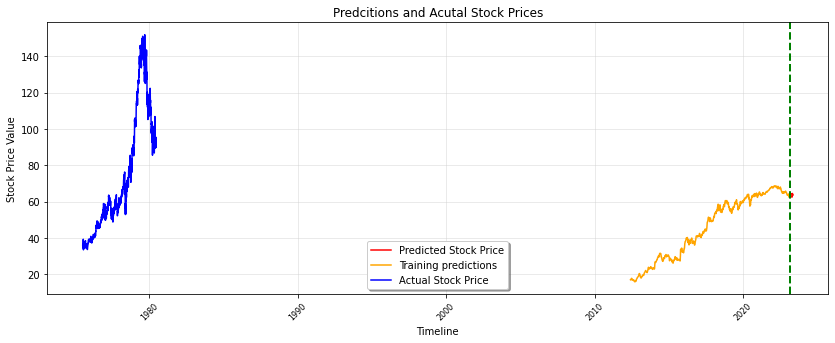

In [19]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Open'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [20]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)